# Related Work

In this notebook we compare rnalib to related work, namely to
* [pybedtools](https://daler.github.io/pybedtools/index.html), a python library wrapping the popular BEDTools utilities and
* [bioframe](https://bioframe.readthedocs.io/), a genomics library based on pandas dataframes.
* [HTSeq](https://htseq.readthedocs.io/), a Ppython package for analysis of high-throughput sequencing data.

_Pybedtools_ enables various set theory operations on genomic dataset (such as intersect, merge, count, complement,
and shuffle) in various data formats (BAM, BED, GFF/GTF and VCF) and also supports data streaming.
_Bioframe_ is built on top of _pandas_ dataframes and provides a flexible and scalable API for working with genomic
intervals. _HTSeq_, like _rnalib_, partially wraps pysam and provides methods for the annotation of genomic intervals.
In this regard, the functionality of all three libraries overlaps partially with _rnalib_ and its genomic iterators that are built on top of the _pysam_ implementation.

All compared libraries implement different data access approaches, each having pros and cons in different access scenarios:
* _Pybedtools_ is built on the efficient implementation of BEDtools but provides no random access features which means that some filtering tasks require preprocessing the whole dataset 
when just a small subset is needed.
* _Bioframe_ leverages the efficient implementation of pandas dataframes but needs to load the whole dataset into
memory before it can be processed.
* _HTSeq_ is, like _rnalib_ based on pysam but is more low-level and exposes _pysam_'s random access features only for some data formats (e.g., BAM)
* _rnalib_ is built on the efficient implementation of _pysam_ and _pyBigWig_ and leverages indexing data structures of genomics
datasets (e.g., BAM or tabix indices) for efficient random access

In the [first section](#Performance-comparison) of this notebook, we compare the performance of the different libraries in different scenarios in order to highlight their respective strengths and weaknesses. In a summary, _rnalib_'s iterators (based on the respective pysam implementation) are partially outperformed by other implementations if whole datasets are considered/iterated but are much faster when only subregions are considered due to its efficient random access features.

Overall, however, please note that iterating over large interval sets is generally considered slow and is often not needed. In many cases you can use list comprehension, vectorisation or mechanisms such as _pandas_ `apply()` or _pybedtools_ `each()`. Nevertheless, there are scenarios in which we consider iteration useful, e.g., if you need to access to contextual data (e.g., annotation results from previous data rows) or if you need (fine-grained) access to multiple synchronized datasets in parallel. Performance drawbacks of iteration approaches are also diminished when integrating multiple iterators in parallel. 


Another perspective is that during a design/development phase of novel algorithms, code readability and reproducibility are more important than pure 
code performance. _Rnalib_ enables developers to quickly apply their code to either whole datasets or particular (complex) sub-regions and we have added
several assertions and sanity checks that can reduce potential error sources. Thus, while some of the compared libraries might be faster in certain scenarios than the corresponding _rnalib_ iterators, it might also a bit 'unsafer' to use them as discussed in the [pitfalls section](#Potential-pitfalls) of this notebook wher we demonstrate some potential pitfalls of the compared libraries and discuss _rnalib_'s strategies to avoid those.


Finally, we envision that user's would like to mix and match _rnalib_ with other genomics libaries  based on the actual use-case and performance requirements. 
Users could, for example, use _BEDtools_ set operations on some input file, store these files and then run a _rnalib_ analysis on them. 
To facilitate seamless workflows that integrate both libraries, we implemented a `PybedtoolsIterator` that wraps a pybedtools BedTool while implementing the full _rnalib_ interface (e.g., region filtering, stats output).
Users can also use _rnalib_ to instantiate an annotated transcriptome, convert it to a _pandas_ dataframe and use _bioframe_ for further analysis or use the `BioframeIterator` to iterate a bioframe.
_Rnalib_ genomic intervals can also converted to _HTSeq_ intervals (`GI.to_htseq()`) and used in respective analyses.

The following table provides an overview of some popular genomics datasets that are supported by the compared libraries:

| Format | pybedtools | bioframe | HTSeq    | rnalib|
|--------|------------|----------|----------|-------|
| TSV    | +          | +        | -        |  +    |
| BED    | +          | +        | +        |  +    |
| GFF/GTF| +          | +        | +        |  +    |
| VCF    | +          | +        | +        |  +    |
| BAM    | +          | +        | +        |  +    |
| BigBed | +          | +        | +        |  +    |
| BigWig | -          | +        | +        |  +    |
| FASTA  | -          | +        | +        |  +    |
| FASTQ  | -          | -        | +        |  +    |

# TOC
This notebook is structures into three sections:
* A [section](#Performance-comparison) that compares the iteration performance of different genomics libraries
* A [section](#Potential-pitfalls) that highlights potential pitfalls when working with genomics datasets and _rnalib_'s strategies to migtigate this
* A [section](#Memory-usage) that gives some insights into the memory consumption of _rnalib_ objects

In [141]:
# set path and load rnalib
import os, pathlib, platform
import biotite.sequence as seq
from Bio.Align import PairwiseAligner
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import pysam
import numpy as np
import pprint
import pybedtools
import HTSeq
import bioframe
import tempfile
import pytest
import dataclasses
import random
from IPython.core.display import HTML
# load rnalib
import rnalib as rna
from rnalib import gi, SEP, display_textarea

# visualization related settings
plt.rcParams["figure.figsize"] = (20,3)
HTML('<style>table {align:left;display:block}</style>')

display(f"Running rnalib {rna.__version__} on python {platform.python_version()}")
rna.__RNALIB_TESTDATA__ = "rnalib_testdata/"

'Running rnalib 0.0.2 on python 3.12.1'

## Test datasets

This notebook as well as rnalib's testing suite use various test resources (genomics data files and indexing structures) that can be created by 
running the rnalib `rnalib_create_testdata` script or by calling the `testdata.create_testdata()` method. There are two seperate resource sets:

* test_resources: small test datasets that are used by rnalib's test suite
* large_test_resources: larger test files that are needed to demonstrate rnalib under realistic conditions. 

Rnalib knows about the test data directory via the package-global __RNALIB_TESTDATA__ variable. This variable can either be set via the "RNALIB_TESTDATA" environment variable or by monkeypatching (rna.__RNALIB_TESTDATA__ = <mydir>) as shown below. Once this is done, test data resources can be accessed via 
`get_resource(<resource_id>)`. Rnalib will recreate these resources only if they are not found in the provided output folder.


In [130]:
if not os.path.isdir(rna.__RNALIB_TESTDATA__):
    os.mkdir(rna.__RNALIB_TESTDATA__)
    display("Creating testdata at {rna.__RNALIB_TESTDATA__ }")
    rna.testdata.create_testdata(rna.__RNALIB_TESTDATA__, 
                                 rna.testdata.large_test_resources)
else:
    display(f"Testdata at {rna.__RNALIB_TESTDATA__}")
    display_textarea('\n'.join(rna.dir_tree(pathlib.Path(rna.__RNALIB_TESTDATA__))))

'Testdata at rnalib_testdata/'

## Performance comparison
In this section we compare iteration speed for various iterators in different scenarios and plot the results.
Note that many factors are influencing these benchmarks (such as I/O speed, memory consumption, file composition, etc.) so be careful when drawing conclusions.




### Calculate average feature lengths
In this example, we compare different ways to calculate the average feature length in a medium-sized bed file (from the pybedtools testdata repository).
- _rnalib_'s BedIterator is a bit faster than _pybedtools_ which relies on the bedtools implementation for iterating the full bed file
- The _bioframe_ approach is much faster for this task as it first loads the whole dataset into a pandas dataframe that then allows very efficient calculation of mean feature lengths
- The _HTSeq_ approach is fastest as it directly reads and parses the BED file without additional overhead  

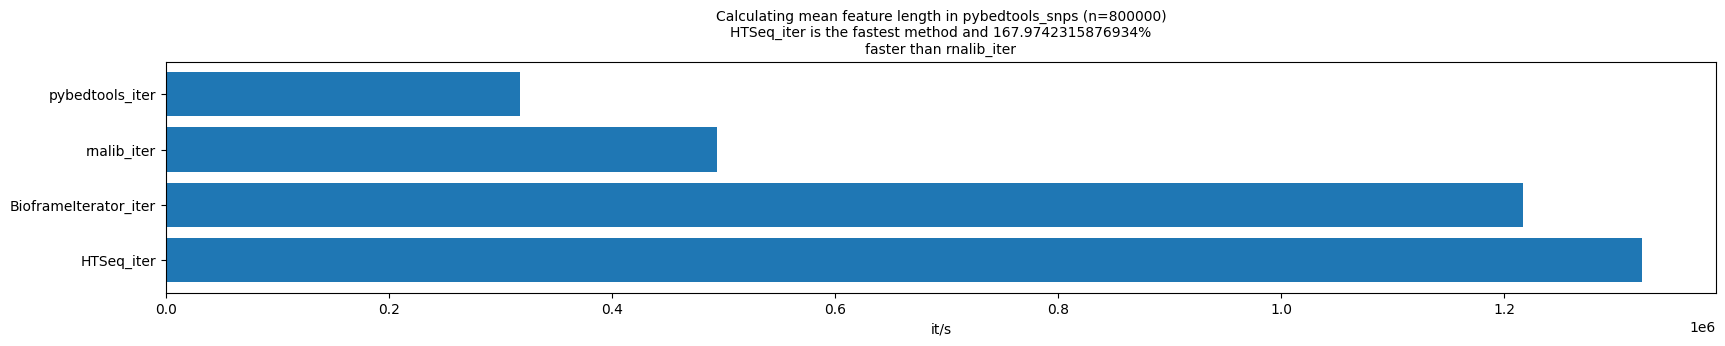

In [11]:
dataset='pybedtools_snps'
bed_file = rna.get_resource(dataset)
times, data=Counter(),Counter()
# rnalib BED iterator.
with rna.Timer(times, 'rnalib_iter') as timer:
    data[timer.name] = []
    with rna.BedIterator(bed_file) as it:
        data[timer.name]=np.mean([len(loc) for loc,_ in it])
        stats=it.stats
# pybedtools 
with rna.Timer(times, 'pybedtools_iter') as timer:
    data[timer.name] = np.mean([x.end-x.start for x in pybedtools.BedTool(bed_file)])
# HTSeq
with rna.Timer(times, 'HTSeq_iter') as timer:
    data[timer.name] = np.mean([x.iv.length for x in HTSeq.BED_Reader(bed_file) ])
# bioframe
with rna.Timer(times, 'BioframeIterator_iter') as timer:
    with rna.BioframeIterator(bed_file) as it:
        it.df['len']=it.df['end']-it.df['start']
        data[timer.name] = it.df['len'].mean()

    
# assert that results match
assert len({y for y in data.values()})==1, f"Error in some computation: {data}"

n = sum([c for (a,_),c in stats.items() if a=='yielded_items'])
rna.plot_times(f"Calculating mean feature length in {dataset} (n={n})",
           times, n=n,
           reference_method='rnalib_iter')

### Grouped aggregation
Here we test grouped aggregation of some property using random datasets. First, we create a data frame with random intervals and random values between [0; 1000] and store it as bgzipped+tabixed bedgraph file. Then we test different methods for calculating a chromosome-grouped mean score. 

- For _pybedtools_, we intersect the file per chromosome, store the values in a numpy array and calculate the mean
- In a second approach, we iterate the whole file and sum and count values in a per-chromosome dict. We then calculate the mean from these values.
- We use a corresponding approach for the _HTSeq_ BED_Reader
- For _bioframe_, we use the _rnalib_ `BioframeIterator` class just for loading the dataframe and then group/aggregate directly with pandas functionality
- We use _rnalib_'s `BedGraphIterator` for iterating the values per chromosome, store them in a numpy array and calculate the mean

Results:
- _Bioframe_ is the fastest option for this task due to the effienct _pandas_ data grouping/aggregation functionality.
- _HTSeq_ outperforms _bioframe_ at first but is overtaken when larger files are considered
- _rnalib_'s `BedGraphIterator` finishes third as per-chromosome grouping is more efficiently handled than intersection in pybedtools
- _Pybedtools_ iteration is a bit slower than _rnalib_
- _Pybedtools_ intersection per chromosome is the slowest approach in this scenario

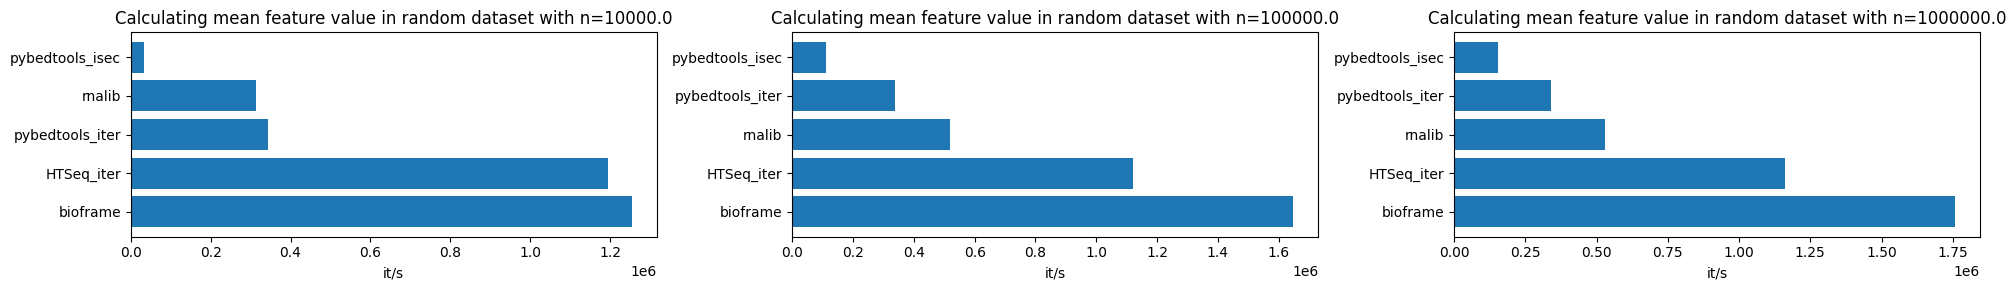

In [13]:
# from rnalib.testdata import make_random_intervals
sizes=[1e4,1e5,1e6]
chroms=['chr' + str(i + 1) for i in range(20)]
fig, axes = plt.subplots(ncols=len(sizes), squeeze=True)
stats=Counter()
for n,ax in zip(sizes,axes):
    with tempfile.TemporaryDirectory() as tempdirname:
        dataset='random dataset'
        bed_file=f'{tempdirname}/data.bedgraph'
        # create testdata
        rna.testdata.make_random_intervals(n=n, chroms=chroms).to_csv(bed_file, sep='\t', encoding='utf-8', index=False, header=False)
        #rna.print_small_file(bed_file)
        rna.bgzip_and_tabix(bed_file)
        bed_file+='.gz'
        times, data, stats=Counter(),Counter(),Counter()        
        # rnalib
        with rna.Timer(times, 'rnalib') as timer:
            data[timer.name] = {}
            for chrom in chroms:
                with rna.BedGraphIterator(bed_file, region=chrom) as it:
                    data[timer.name][chrom]=np.mean([v for _,v in it])
                    stats.update(it.stats)
        # pybedtools - iterate
        with rna.Timer(times, 'pybedtools_iter') as timer:
            data[timer.name] = {}
            d, s = Counter(), Counter()
            for x in pybedtools.BedTool(bed_file):
                s[x.chrom]+=float(x.name)
                d[x.chrom]+=1
            for chrom in chroms:
                data[timer.name][chrom] = s[chrom]/d[chrom]
        # pybedtools - intersect
        with rna.Timer(times, 'pybedtools_isec') as timer:
            data[timer.name] = {}
            for chrom in chroms:
                data[timer.name][chrom] = np.mean([float(x.name) for x in pybedtools.BedTool(bed_file).intersect([gi(chrom).to_pybedtools()], u=True)])
        # HTSeq
        with rna.Timer(times, 'HTSeq_iter') as timer:
            data[timer.name] = {}
            d, s = Counter(), Counter()
            for x in HTSeq.BED_Reader(bed_file):
                s[x.iv.chrom]+=float(x.name)
                d[x.iv.chrom]+=1
            for chrom in chroms:
                data[timer.name][chrom] = s[chrom]/d[chrom]
        # bioframe
        with rna.Timer(times, 'bioframe') as timer:
            with rna.BioframeIterator(bed_file) as it:
                data[timer.name] = it.df.groupby('chrom')['name'].mean().to_dict()
        # assert that results match
        for c in chroms:
            assert rna.check_list([data[x][c] for x in data.keys()], 'eq'),\
                f"Error on chrom {c}!"
        # plot the results
        rna.plot_times(f"Calculating mean feature value in {dataset} with n={n}",
                   times, n=np.sum([stats['yielded_items',c] for c in chroms]),
                   reference_method='rnalibr',
                   ax=ax)
plt.tight_layout()
plt.show()

### Value-filtered iteration
Here we compare various methods for iterating a bed file and filtering for entries with a given minimum length.

We compare _HTSeq_'s `BED_Reader`, _bioframe_, _pybedtools_ iterators with various filter options and _ rnalib_ 's `BedIterator`.
We also include one approach in which we first filter via _pybedtools_, save the file and then iterate via a `PybedtoolsIterator` (pybedtools+rnalib_pybedtoolsiterator).

In this scenario, no pre-filtering based on genomic location is possible and HTSeq wins again due to its minimal overhead when iterating the full BED file, closely followed by _bioframe_.
_Rnalib_ finishes third, slightly faster than the compared _pybedtools_ approaches.

RefDict (size: 2): dict_keys(['chr1', 'chr21']), dict_values([None, None]) name: References from TABIX file b'rnalib_testdata//bed/pybedtools_snps.bed.gz' 
Filtered BED to create /var/folders/kp/q945z6v94jl3myn35wzsl5n00000gp/T/pybedtools.rl08byq9.tmp


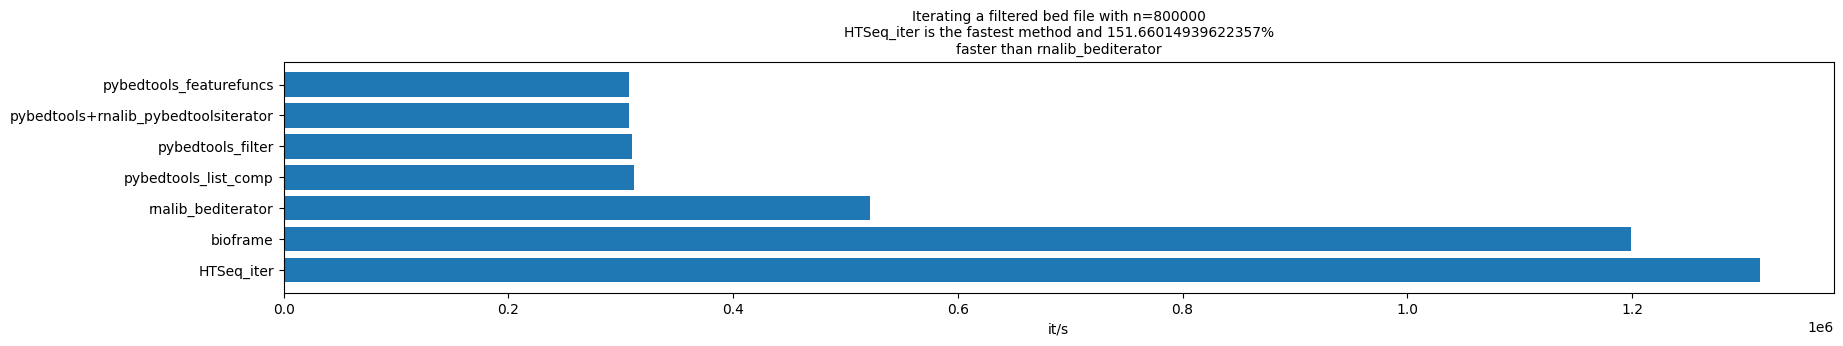

In [18]:
from pybedtools.featurefuncs import greater_than
bed_file = rna.get_resource('pybedtools_snps')  
stats,times,data=Counter(),Counter(),Counter()
minlen = 5
with rna.Timer(times, 'pybedtools_filter') as timer:
    # BedTools with filter()
    data[timer.name] = [x.name for x in pybedtools.BedTool(bed_file).filter(lambda x: len(x) > minlen)]
with rna.Timer(times, 'pybedtools_list_comp') as timer:
    # BedTools with list comprehension
    data[timer.name] = [x.name for x in pybedtools.BedTool(bed_file) if len(x) > minlen]
with rna.Timer(times, 'pybedtools_featurefuncs') as timer:
    # BedTools with filter()/featurefuncs
    data[timer.name] = [x.name for x in pybedtools.BedTool(bed_file).filter(greater_than, minlen)]
with rna.Timer(times, 'rnalib_bediterator') as timer:
    # native rnalib iterator. Collect stats from here
    with rna.BedIterator(bed_file) as it:
        data[timer.name] = [snp.data.name for snp in it if len(snp)>minlen]
        stats=it.stats # we also get some stats here...
with rna.Timer(times, 'pybedtools+rnalib_pybedtoolsiterator') as timer:
    # here we first filter via pybedtools, save the file and then iterate via a PybedtoolsIterator
    bt=pybedtools.BedTool(bed_file).filter(greater_than, minlen).saveas()
    # note: as 
    with rna.PybedtoolsIterator(bt, refdict=rna.RefDict.load(bed_file)) as it:
        print(f"Filtered BED to create {bt.fn}")
        data[timer.name] = [snp.data.name for snp in it]
    # HTSeq
with rna.Timer(times, 'HTSeq_iter') as timer:
    data[timer.name] = [x.name for x in HTSeq.BED_Reader(bed_file) if x.iv.length>minlen]
    # bioframe
with rna.Timer(times, 'bioframe') as timer:
    with rna.BioframeIterator(rna.get_resource('pybedtools_snps')) as it:
        data[timer.name] = it.df.query(f"end-start>{minlen}")['name'].to_list()   

# check results
assert len({len(y) for y in data.values()})==1, f"Error in some computation: {data}"

# calc speed improvement
n = sum([c for (a,_),c in stats.items() if a=='yielded_items'])
rna.plot_times(f"Iterating a filtered bed file with n={n}",
           times, n,
           reference_method='rnalib_bediterator')

### Location-filtered iteration
Here we add some more filtering steps and compare different methods for counting minus strand features on one chromosome in a large GFF3 file that is downloaded from gencode to a temporary directory, sorted, bgzipped, index and then analysed. We restrict this analysis to one chromosome only.

- for _pybedtools_, we either intersect the file with the respective region of interest or apply a filter method, then parse the respective fields and count
- for _bioframe_, we init a filtered DataFrame via our BioframeIterator implementation, filter for the proper strand and region using pandas and then iterate+count
- for _HTSeq_, we iterate over a `GFF_Reader`, filter by interval strand and count the returned feature_type 
- for _rnalib_, we use a chromosome-filtered `GFF3Iterator` for comparison, filter by interval strand and count the returned feature_type 

Results:
- The _HTSeq_ approach is slowest. Pre-filtering on chromome is not possible as no random access interface is available. 
- The _pybedtools_filter_ option is also relatively slow and also needs to iterate the whole dataset when filtering.
- The shown _pandas_/_bioframe_ approach first needs to read the whole dataframe into memory before it can efficiently filter in two steps for the targeted genomic region and strand. 
- The _pybedtools_intersect_ option is much faster as it only needs to iterate the specified chromosome after (the costly) intersection 
- Finally, the rnalib GFF3Iterator (based on pysam) is the fastest option due to the fast chromosome filtering based on the leveraged tabix index.

INFO:root:filtering dataframe for region chr21:0-2147483647


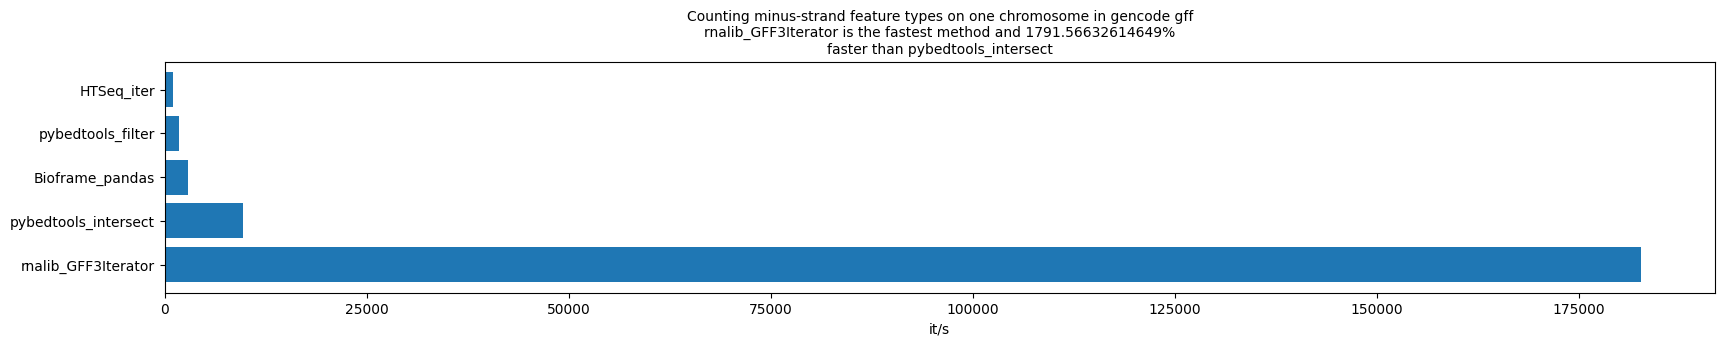

In [19]:
gff_file=rna.get_resource("full_gencode_gff")
roi=gi('chr21') # count on one chromosome only
times, data=Counter(),Counter()
with rna.Timer(times, 'pybedtools_filter') as timer:
    data[timer.name]=Counter()
    # Alternatively we could use BedTools with list comprehension or with filter()/featurefuncs
    for x in pybedtools.BedTool(gff_file).filter(lambda b: b.chrom == roi.chromosome and b.strand=='-'):
        feature_type = x.fields[2]
        data[timer.name][feature_type]+=1
        data[timer.name]['-']+=1
with rna.Timer(times, 'pybedtools_intersect') as timer:
    data[timer.name]=Counter()
    for x in pybedtools.BedTool(gff_file).intersect([roi.to_pybedtools()], u=True):
        strand, feature_type = x.strand, x.fields[2]
        if strand == '-':
            data[timer.name][feature_type]+=1
            data[timer.name][strand]+=1
with rna.Timer(times, 'rnalib_GFF3Iterator') as timer:
    data[timer.name]=Counter()
    with rna.GFF3Iterator(gff_file, region=roi) as it:
        for loc, info in it: # now iterate the values
            if loc.strand=='-':
                data[timer.name][info['feature_type']]+=1
                data[timer.name][loc.strand]+=1
        stats=it.stats      
with rna.Timer(times, 'HTSeq_iter') as timer:
    data[timer.name]=Counter()
    for x in HTSeq.GFF_Reader(gff_file):
        if x.iv.strand == '-' and x.iv.chrom == roi.chromosome:
            data[timer.name][x.type]+=1
            data[timer.name][x.iv.strand]+=1
with rna.Timer(times, 'Bioframe_pandas') as timer:
    with rna.BioframeIterator(gff_file, region=roi) as it: # init filtered dataframe
        it.df = it.df.query("strand=='-'") # further filter the dataframe with pandas
        data[timer.name]=Counter(it.df['strand'])
        data[timer.name].update(Counter(it.df['feature']))

# check results and assert that they match
res=None
for k in times.keys():
    if res is None:
        res = data[k]
    else:
        assert data[k] == res

# plot the timings
rna.plot_times(f"Counting minus-strand feature types on one chromosome in gencode gff",
           times, n=stats[('yielded_items', roi.chromosome)],
           reference_method='rnalib_GFF3Iterator')    

### Summary

While _rnalib_ is slower than some of the compared approaches when a whole dataset is considered, it greatly outperforms them when only a subregion of the dataset needs to be iterated due to its efficient random access features that are built on pysam's functionality. Please note, that iteration performance was no primary design goal of _rnalib_. This performance comparison should solely demonstrate where our implementation stands wrt. other libraries and highlight its benefits when random access is needed.

## Potential pitfalls

In this section we demonstrate common pitfalls that regularly hamper bioinformatics analyses leading to wrong results: 
- [unsorted input files](#Pybedtools-unsorted-input-example)
- [wrongly interpreted coordinate systems](#bioframe-coordinate-mixup-example)
- [mutable interval implementations](#Mutable-interval-pitfalls)

We showcase those problems below using realistic scenarios.
Notably, in most cases *analyses run through and deliver plausible (yet wrong) results* which makes these kinds of errors hard to catch.

### Pybedtools unsorted input example

Here, we demonstrate how unsorted input may lead to wrong analysis results using _pybedtools_. The following code block was copy-pasted from the [pybedtools page](https://github.com/daler/pybedtools) and the idea of this example is to create a list of gene names that are <5 kb away from intergenic SNPs. However, this code does not work properly (with pybedtools v0.9.1) due to inconsistent chromosome order of the two input files (hg19.gff: chr1, chr21; snps.bed.gz: chr21, chr1; both are _pybedtools_ test resources).

As a result, `genes.closest()` reports only -1 as distance which is why all closes genes will be reported, not just the ones at max 5kb distance.
Notably, the code runs without errors/warnings and returns a reasonable-sized list of gene names which makes it hard to spot the error. 
Only when omitting the `stream=True` flag, `genes.closest()` fails and reports the inconsistent chrom order. 

Note, that in _rnalib_, input files have to be bgzipped and indexed which requires them to be coordinate sorted and that `RefDict`'s are used to ensure consistent chromosome ordering.

In [20]:
def run_pybedtools_example(gff_file, snp_file):
    snps = pybedtools.BedTool(snp_file)  
    genes = pybedtools.BedTool(gff_file)
    intergenic_snps = snps.subtract(genes).saveas()                      
    nearby = genes.closest(intergenic_snps, d=True, stream=True).saveas() 
    nbgenes = [gene.name for gene in nearby if int(gene[-1]) < 5000]
    display(f"We found {len(nbgenes)} nearby genes. Unique names: {len(set(nbgenes))}")


display("Unsorted input files:")
run_pybedtools_example(rna.get_resource("pybedtools::hg19.gff"), rna.get_resource("pybedtools::snps.bed.gz"))
display("Sorted input files:")
run_pybedtools_example(rna.get_resource("pybedtools_gff"), rna.get_resource("pybedtools_snps"))

'Unsorted input files:'

'We found 4217 nearby genes. Unique names: 4215'

'Sorted input files:'

'We found 2422 nearby genes. Unique names: 2419'

### Bioframe coordinate mixup example

In _bioframe_, interval coordinates are "[... assumed to be 0-based and intervals half-open (1-based ends) i.e. (start, end)](https://bioframe.readthedocs.io/en/latest/guide-definitions.html#definitions)" as, for example, in the BED file format.
However, this is not enforced or validated when reading genomic datasets in different formats (e.g., GFF) which results in bioframe wrongly interpreting 1-based as 0-base coordinates a demonstrated in the following snippet. Such errors shifts start coordinates of misinterpreted datasets by 1bp and may lead to subtle errors in downstream analyses. 
Note, that _rnalib_ provides format-specific iterators that ensure proper coordinate interpretation which makes it harder (yet not impossible) to fall into this pit. 

In [21]:
# let's load a GFF file and a corresponding BED file with the bioframe.read_table() method (you can use igv to check they 
# are indeed representing the same intervals). The BED file was created with bedops gff2bed: 
# "gff2bed -d < gencode_44.ACTB+SOX2.gff3 | cut -f1-6 | bgzip > gencode_44.ACTB+SOX2.bed.gz"
bioframe_gff = bioframe.read_table(rna.get_resource("gencode_gff"), schema='gff')[['chrom','start','end', 'strand']]
bioframe_bed = bioframe.read_table(rna.get_resource("gencode_bed"), schema='bed')[['chrom','start','end', 'strand']]
assert bioframe.is_bedframe(bioframe_gff) and bioframe.is_bedframe(bioframe_bed) # assert that they are 'bedframes'

# let's compare them using pandas compare...
display('bioframe:', bioframe_gff.compare(bioframe_bed))
# so we see that the start coordinates indeed differ by one

# Now load via rnalib
rnalib_gff = pd.DataFrame([(loc.chromosome, loc.start, loc.end, loc.strand) \
                             for loc, info in rna.GFF3Iterator(rna.get_resource("gencode_gff"))],
                           columns=['chrom','start','end','strand'])
rnalib_bed = pd.DataFrame([(loc.chromosome, loc.start, loc.end, loc.strand) \
                             for loc, info in rna.BedIterator(rna.get_resource("gencode_bed"))],
                           columns=['chrom','start','end','strand'])

display('rnalib:', rnalib_gff.compare(rnalib_bed))
# no differences as expected as the iterators will convert the coordinates appropriately

'bioframe:'

start           
          self      other
0    180989762  180989761
1    180989770  180989769
2    180989770  180989769
3    180989771  180989770
4    180989773  180989772
..         ...        ...
340    5562574    5562573
341    5562574    5562573
342    5562574    5562573
343    5563714    5563713
344    5563714    5563713

[345 rows x 2 columns]

'rnalib:'

Empty DataFrame
Columns: []
Index: []

### Mutable interval pitfalls

Another, more subtle, pitfall results from how genomic intervals and their annotations are implemented in the different python libraries.
In most cases, intervals are implemented as [mutable](https://realpython.com/python-mutable-vs-immutable-types/) objects whose values can be changed at runtime.
Often these interval objects also contain associated (mutable) meta-data (such as interval names, scores, etc.). 
This, however, means that updates of intervals or associated meta-data results in changed hash values of the respective objects as shown below.
This makes them unsafe to use as keys in referencing datastructures such as dicts and can lead to unwanted side-effects. 

In *rnalib*, [genomic intervals](#Genomic-intervals) and their annotations are modeled separatedly with the former being implemented as namedtuples or  [frozen (basically immutable) dataclasses](https://docs.python.org/3/library/dataclasses.html#frozen-instances) while the latter being stored in a dict-like datastructure that is indexed by the respective interval. The following codeblocks demonstrates the different approaches.

In [29]:
# ======================
# pybedtools intervals are mutable
# implementation: https://github.com/daler/pybedtools/blob/master/pybedtools/cbedtools.pyx
# ======================
display('Pybedtools intervals are mutable:')
i = pybedtools.Interval("chr1", 22, 44, strand='-') # create a pybedtools interval
i.name='A' # set a metadata attribute of this interval
cache = { i : 'interval found in cache.' } # use it as key in a dict
display(f"{id(i)}, {i.__hash__()}, {i.name}, {cache.get(i, "interval NOT found in cache!")}") # show object id and hash value and do lookup

i.name = 'B' # now we can just mutate the interval name, but this will change the hash value of this object!
display(f"{id(i)}, {i.__hash__()}, {i.name}, {cache.get(i, "interval NOT found in cache!")}") # show object id and hash value and do lookup

'Pybedtools intervals are mutable:'

'12255706560, 6347235111095947791, A, interval found in cache.'

'12255706560, 1908353498805443296, B, interval NOT found in cache!'

In [139]:
# ======================
# HTSeq intervals are mutable
# ======================
import HTSeq
display('HTSeq intervals are mutable:')
i = HTSeq.GenomicInterval("chr1", 22, 44, strand='-') # create a htseq genomic interval
gas = HTSeq.GenomicArrayOfSets( "auto", stranded=True) # use a GAoS to associate string metadata
gas[i] += "A"
cache = { i : 'interval found in cache.' } # use it as key in a dict
# show object id, hash value, access in GAoS and do dict lookup
display(f"{id(i)}, {i.__hash__()}, {[x for x in gas[i].steps()]}, {cache.get(i, "interval NOT found in cache!")}") # show object id and hash value and do lookup

i.strand = '+'# now we can just mutate the strand of the interval, but this will change the hash value of this object. 
display(f"{id(i)}, {i.__hash__()},  {[x for x in gas[i].steps()]}, {cache.get(i, "interval NOT found in cache!")}") # lookup
with pytest.raises(NotImplementedError):
    display(f"Also note that HTSeq GenomicArrays and derived datastructures do not implement the __contains__() method!")
    i in gas # this does not work ans raises a NotImplementedError

'HTSeq intervals are mutable:'

"18988780464, -6903747783704771670, [(<GenomicInterval object 'chr1', [22,44), strand '-'>, {'A'})], interval found in cache."

"18988780464, 4151293875779523291,  [(<GenomicInterval object 'chr1', [22,44), strand '+'>, set())], interval NOT found in cache!"

'Also note that HTSeq GenomicArrays and derived datastructures do not implement the __contains__() method!'

In [31]:
# ======================
# rnalib genomic intervals are immutable
# ======================
display('rnalib intervals are immutable:')
i = gi("chr1", 22, 44, strand='-') # create a rnalib interval
with pytest.raises(AttributeError):
    i.start = 21 # This will raise an 'AttributeError', you cannot mutate genomic intervals!
cache = { i : {'mess':'interval found in cache.', 'name':'A'} } # put it in a dict and add also the interval Name
display(f"{id(i)}, {i.__hash__()}, {cache[i]['name']}, {cache[i]['mess']}") # show object id and hash value and do lookup

cache[i]['name']='B'
display(f"{id(i)}, {i.__hash__()}, {cache[i]['name']}, {cache[i]['mess']}") # show object id and hash value and do lookup


'rnalib intervals are immutable:'

'15733174208, -6903747783704771670, A, interval found in cache.'

'15733174208, -6903747783704771670, B, interval found in cache.'

### Interval definition differences

Genomic interval definitions differ between the considered libraries (rnalib, pybedtools and bedframe).
Here are some differences:
- _rnalib_ supports empty and unbounded intervals. The length of the latter is calculated from the chrom length if possible or zero otherwise.
- _pybedtools_ makes little assertions on the parsed intervals. It is possible to provide files with start>end coordinates or empty intervals (start==end).
  Notably, the reported length of start>end intervals is wrong, as demonstrated
- HTSeq does not support interval with start>end.


In [32]:
display(f"Reported lengths for [1; 1] interval: rnalib: {len(gi('chr1', 1, 1))}, pybedtools: {len(pybedtools.Interval('chr1',0,1))}, HTSeq: {HTSeq.GenomicInterval('chr1',0,1).length}")  
display(f"Reported lengths for [1; 2] interval: rnalib: {len(gi('chr1', 1, 2))}, pybedtools: {len(pybedtools.Interval('chr1',0,2))}, HTSeq: {HTSeq.GenomicInterval('chr1',0,2).length}")  
display(f"Reported lengths for [2; 1] interval: rnalib: {len(gi('chr1', 2, 1))}, pybedtools: {len(pybedtools.Interval('chr1',1,1))}, HTSeq: {HTSeq.GenomicInterval('chr1',1,1).length}")  
display(f"Reported lengths for [2; 1] interval: rnalib: {len(gi('chr1', 2, 1))}, pybedtools: {len(pybedtools.Interval('chr1',2,1))}, HTSeq: not supported. Emulate with rnalib: {gi('chr1', 2, 1).to_htseq().length}") 
display(f"Reported lengths for [1; ...] interval: rnalib: {len(gi('chr1', 1))}, rnalib/pybedtools: {len(gi('chr1', 1).to_pybedtools())}, HTSeq: {HTSeq.GenomicInterval('chr1',0,2147483647).length}") 
display(SEP)
# different methods for counting the number of 'empty' intervals in the pybedtools SNP test file
display(f"Number of 'empty' intervals in pybedtools_snps (bioframe): {len(bioframe.read_table(rna.get_resource('pybedtools_snps'), schema='bed').query('start==end').index)}")
display(f"Number of 'empty' intervals in pybedtools_snps (rnalib): {len([loc for loc,_ in rna.BedIterator(rna.get_resource('pybedtools_snps')) if loc.is_empty()])}")
display(f"Number of 'empty' intervals in pybedtools_snps (pybedtools): {len(pybedtools.BedTool(rna.get_resource('pybedtools_snps')).filter(lambda x: x.start==x.end))}")
display(f"Number of 'empty' intervals in pybedtools_snps (HTSeq): {len([br.iv for br in HTSeq.BED_Reader(rna.get_resource('pybedtools_snps')) if br.iv.start == br.iv.end])}")

'Reported lengths for [1; 1] interval: rnalib: 1, pybedtools: 1, HTSeq: 1'

'Reported lengths for [1; 2] interval: rnalib: 2, pybedtools: 2, HTSeq: 2'

'Reported lengths for [2; 1] interval: rnalib: 0, pybedtools: 0, HTSeq: 0'

'Reported lengths for [2; 1] interval: rnalib: 0, pybedtools: 4294967295, HTSeq: not supported. Emulate with rnalib: 0'

'Reported lengths for [1; ...] interval: rnalib: 2147483647, rnalib/pybedtools: 2147483647, HTSeq: 2147483647'

---

"Number of 'empty' intervals in pybedtools_snps (bioframe): 1564"

"Number of 'empty' intervals in pybedtools_snps (rnalib): 1564"

"Number of 'empty' intervals in pybedtools_snps (pybedtools): 1564"

"Number of 'empty' intervals in pybedtools_snps (HTSeq): 1564"

# Memory usage

Here, we use the [objsize](https://github.com/liran-funaro/objsize) library to estimate mean memory size for various _rnalib_ objects, including a full gencode transcriptome and its individual genomic features.

In [143]:
#%pip install objsize==0.7.0
import objsize, sys, math, collections
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

In [103]:
# load full gencode transcriptome 
t_gc=rna.Transcriptome(
    annotation_gff = rna.get_resource("full_gencode_gff"),
    annotation_flavour ='gencode',
    copied_fields =['gene_type', 'transcript_type'])
t_gc, t_gc.log
# for excluding objects
gene_ids={id(g) for g in t_gc.genes} # set of ids of gene objects
tx_ids={id(g) for g in t_gc.transcripts} # set of ids of tx objects

Building transcriptome (25 chromosomes)
:   0%|          | 0/25 [00:00<?, ?it/s]

Build interval trees:   0%|          | 0/61533 [00:00<?, ?it/s]

In [104]:
# sampled subsets
samples={}
samples['rnd_features'] = random.sample(sorted(t_gc.anno.keys()), 10000)
samples['rnd_genes'] = random.sample(sorted(t_gc.genes), 10000)
samples['rnd_transcripts'] = random.sample(sorted(t_gc.transcripts), 10000)
# stats
stats = collections.Counter()
stats['n_genes'] = len(t_gc.genes)
stats['n_transcripts'] = len(t_gc.transcripts)

In [105]:
stats['total_size_transcriptome_wo_seq'] = objsize.get_deep_size(t_gc)
display(f"Size of full transcriptome (w/o seq): {convert_size(stats['total_size_transcriptome_wo_seq'])}")

'Size of full transcriptome (w/o seq): 2.12 GB'

In [106]:
stats['mean_size_location'] = np.array([objsize.get_deep_size(feature.location) for feature in samples['rnd_features']]).mean()
display(f"Mean size per location: {convert_size(stats['mean_size_location'])}")

'Mean size per location: 215.47 B'

In [107]:
stats['mean_size_gene'] = np.array([objsize.get_deep_size(feature, exclude_set={id(t_gc)}) for feature in samples['rnd_genes']]).mean()
display(f"Mean size per gene: {convert_size(stats['mean_size_gene'])}")

'Mean size per gene: 30.09 KB'

In [109]:
stats['mean_size_transcript'] = np.array([objsize.get_deep_size(feature, exclude_set={id(t_gc)}| gene_ids) for feature in samples['rnd_transcripts']]).mean()
display(f"Mean size per transcript: {convert_size(stats['mean_size_transcript'])}")

'Mean size per transcript: 7.31 KB'

In [110]:
stats['mean_n_transcript_per_gene'] = np.array([len(g.transcript) for g in t_gc.genes]).mean()
display(f"Mean #tx per gene: {stats['mean_n_transcript_per_gene']}")

'Mean #tx per gene: 3.980612029317602'

In [111]:
t_gc.genome_fa="/Users/niko/Desktop/data/ref/genomes/GRCh38/GCA_000001405.15_GRCh38_full_plus_hs38d1_analysis_set.fna"
t_gc.load_sequences()

Load sequences:   0%|          | 0/61533 [00:00<?, ?it/s]

In [112]:
stats['total_size_transcriptome_with_seq'] = objsize.get_deep_size(t_gc)
display(f"Size of full transcriptome (with seq): {convert_size(stats['total_size_transcriptome_with_seq'])}")

'Size of full transcriptome (with seq): 4298928990'

In [151]:
stats['mean_size_gene_seq'] =  np.array([objsize.get_deep_size(feature.sequence, exclude_set={id(t_gc)}) for feature in samples['rnd_genes']]).mean()
stats['approx_total_size_gene'] = stats['mean_size_gene']*stats['n_genes']
stats['approx_total_size_gene_seq'] = stats['mean_size_gene_seq']*stats['n_genes']

display(f"Mean size per gene feat: {convert_size(stats['mean_size_gene'])} with approx total of {convert_size(stats['approx_total_size_gene'])}")
display(f"Mean size per gene seq: {convert_size(stats['mean_size_gene_seq'])} with approx total of {convert_size(stats['approx_total_size_gene_seq'])}")

'Mean size per gene feat: 30.09 KB with approx total of 1.77 GB'

'Mean size per gene seq: 32.06 KB with approx total of 1.88 GB'

In [153]:
display('Summary:')
for k,v in stats.items():
    if not k.startswith('n_'):
        display(f"{k}: {convert_size(v)}")

'Summary:'

'total_size_transcriptome_wo_seq: 2.12 GB'

'mean_size_location: 215.47 B'

'mean_size_gene: 30.09 KB'

'mean_size_transcript: 7.31 KB'

'mean_n_transcript_per_gene: 3.98 B'

'total_size_transcriptome_with_seq: 4.0 GB'

'mean_size_gene_seq: 32.06 KB'

'approx_total_size_gene: 1.77 GB'

'approx_total_size_gene_seq: 1.88 GB'